In [23]:
import matplotlib
import seaborn
import pandas
import networkx
import tqdm
import gzip
import igraph

from collections import Counter

%matplotlib inline

In [24]:
ecosystems = ['pypi', 'npm', 'cran']

COLORS = {ecos: seaborn.color_palette()[i] for i, ecos in enumerate(ecosystems)}

In [25]:
def igraph_to_networkx(graph):
    ngraph = networkx.DiGraph() if graph.is_directed() else networkx.Graph()
    nodes = graph.vs['name']
    edges = ((nodes[source], nodes[target]) for source, target in graph.get_edgelist())
    ngraph.add_nodes_from(nodes)
    ngraph.add_edges_from(edges)
    return ngraph

In [26]:
graphs = {}

for ecos in ecosystems:
    with gzip.GzipFile('../../{}/data/packages.csv.gz'.format(ecos)) as f:
        packages = pandas.read_csv(f, index_col=[0,1])
    with gzip.GzipFile('../../{}/data/deps.csv.gz'.format(ecos)) as f:
        deps = pandas.read_csv(f)

    # Take latest version of each package
    packages = packages.sort_values('time').groupby(level=0, sort=False).tail(1)
    deps = packages.merge(deps, how='inner', left_index=True, right_on=['package', 'version']).dropna()

    # Filter out dependencies that are not registered packages
    deps = packages.reset_index().merge(deps, how='inner', left_on='package', right_on='dependency', suffixes=('_2', ''))
    
    # Construct graph
    graph = igraph.Graph(directed=True)
    graph.add_vertices(packages.index.get_level_values('package'))
    edges = [(row.package, row.dependency) for row in deps[['package', 'dependency']].itertuples()]
    graph.add_edges(edges)
    
    graphs[ecos] = graph
    

## Packages and Dependencies

In [27]:
data = {ecos: {} for ecos in graphs.keys()}
for ecos, graph in graphs.items():
    data[ecos]['packages'] = graph.vcount()
    data[ecos]['dependencies'] = graph.ecount()
    data[ecos]['pkg_with_deps'] = len([True for d in graph.outdegree() if d > 0])
    data[ecos]['pkg_with_rev_deps'] = len([True for d in graph.indegree() if d > 0])
    data[ecos]['pkg_non_isolated'] = len([True for d in graph.degree() if d > 0])
    data[ecos]['pkg_isolated'] = len([True for d in graph.degree() if d == 0])
df = pandas.DataFrame.from_dict(data, orient='index')
df

,pkg_isolated,dependencies,pkg_non_isolated,pkg_with_rev_deps,pkg_with_deps,packages
cran,7119,3770,2449,872,1921,9568
npm,109796,725450,207364,66129,185228,317160
pypi,77349,10063,4785,1739,3344,82134


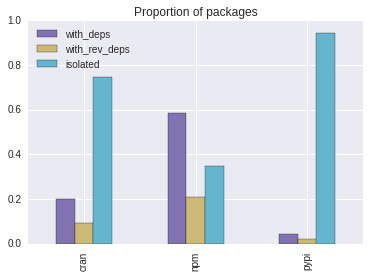

In [28]:
df['with_deps'] = df['pkg_with_deps'] / df['packages']
df['with_rev_deps'] = df['pkg_with_rev_deps'] / df['packages']
df['isolated'] = df['pkg_isolated'] / df['packages']
df[['with_deps', 'with_rev_deps', 'isolated']].plot.bar(title='Proportion of packages', color=seaborn.color_palette()[3:])

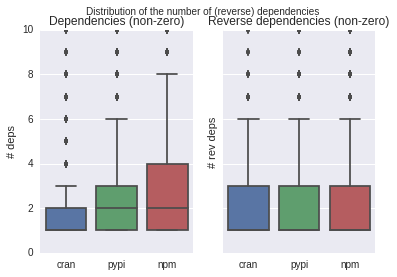

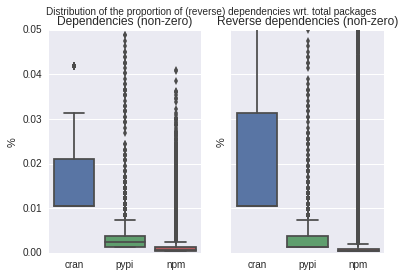

In [29]:
data_in = []
data_in_p = []
data_out = []
data_out_p = []

for ecos, graph in graphs.items():
    n = graph.vcount()
    for d in graph.outdegree():
        if d > 0:
            data_out.append((ecos, d))
            data_out_p.append((ecos, 100 * d / n))
            
    for d in graph.indegree():
        if d > 0:
            data_in.append((ecos, d))
            data_in_p.append((ecos, 100 * d / n))

fig, axes = matplotlib.pyplot.subplots(ncols=2, sharey=True, sharex=True)            
fig.suptitle('Distribution of the number of (reverse) dependencies')

ax = seaborn.boxplot(0, 1, data=pandas.DataFrame.from_records(data_out), ax=axes[0])
ax.set_ylim(0, 10)
ax.set_xlabel('')
ax.set_ylabel('# deps')
ax.set_title('Dependencies (non-zero)')

ax = seaborn.boxplot(0, 1, data=pandas.DataFrame.from_records(data_in), ax=axes[1])
ax.set_ylim(0, 10)
ax.set_xlabel('')
ax.set_ylabel('# rev deps')
ax.set_title('Reverse dependencies (non-zero)')


fig, axes = matplotlib.pyplot.subplots(ncols=2, sharey=True, sharex=True)            
fig.suptitle('Distribution of the proportion of (reverse) dependencies wrt. total packages')

ax = seaborn.boxplot(0, 1, data=pandas.DataFrame.from_records(data_out_p), ax=axes[0])
ax.set_ylim(0, 0.05)
ax.set_xlabel('')
ax.set_ylabel('%')
ax.set_title('Dependencies (non-zero)')

ax = seaborn.boxplot(0, 1, data=pandas.DataFrame.from_records(data_in_p), ax=axes[1])
ax.set_ylim(0, 0.05)
ax.set_xlabel('')
ax.set_ylabel('%')
ax.set_title('Reverse dependencies (non-zero)')

In [30]:
print('Most required packages')
for ecos, graph in graphs.items():
    print(ecos, ':', end=' ')
    for vertex, degree in sorted(zip(graph.vs, graph.indegree()), key=lambda x: x[1], reverse=True)[:10]:
        print('{} ({})'.format(vertex['name'], degree), end=', ')
    print()

print()

print('Most dependent packages')
for ecos, graph in graphs.items():
    print(ecos, ':', end=' ')
    for vertex, degree in sorted(zip(graph.vs, graph.outdegree()), key=lambda x: x[1], reverse=True)[:10]:
        print('{} ({})'.format(vertex['name'], degree), end=', ')
    print()

Most required packages
cran : Rcpp (468), ggplot2 (126), httr (84), dplyr (74), rJava (62), Matrix (55), stringr (51), data.table (49), jsonlite (43), plyr (42), 
pypi : requests (593), numpy (526), six (435), pytest (259), coverage (245), scipy (221), matplotlib (179), pytest-cov (158), check-manifest (154), mock (144), 
npm : lodash (23306), request (14571), async (14089), underscore (11976), commander (9409), express (9365), chalk (8964), debug (8463), bluebird (7261), mkdirp (6326), 

Most dependent packages
cran : radiant (19), AFM (18), SSDM (15), btergm (14), SurvRank (13), Luminescence (13), toaster (13), hyfo (12), spocc (12), CorReg (11), 
pypi : invenio-records-rest (50), invenio-migrator (49), invenio-openaire (48), invenio-previewer (47), invenio-communities (46), gnocchi (43), invenio-logging (40), cameo (40), invenio-files-rest (39), jsonresolver (38), 
npm : mikolalysenko-hoarders (389), terrible-lodash (309), smasher (130), lodash-modularized (129), compute.io (122), b

## Connected components

In [31]:
data = {ecos: {} for ecos in graphs.keys()}
for ecos, graph in graphs.items():
    for component, size in Counter(len(component) for component in graph.components(mode=igraph.WEAK)).items():
        data[ecos][component] = size
df = pandas.DataFrame.from_dict(data)
print('Number of (weakly) connected components by component size')
df.T.fillna(0)

Number of (weakly) connected components by component size


,1,2,3,4,5,6,7,8,9,10,...,27,28,32,35,36,41,106,2126,4349,201593
cran,7119.0,76.0,30.0,8.0,1.0,2.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
npm,109810.0,1486.0,296.0,119.0,40.0,32.0,9.0,11.0,11.0,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
pypi,77349.0,140.0,17.0,4.0,3.0,3.0,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


(0.85850581076176424, 1000000.0)

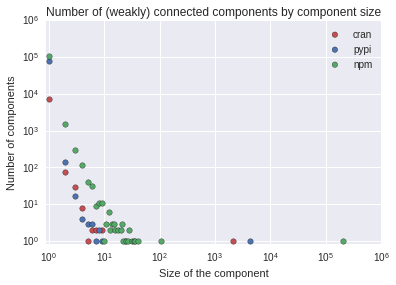

In [32]:
d = df.reset_index().rename(columns={'index': 'component'})
d = pandas.melt(d, id_vars='component', value_vars=['cran', 'npm', 'pypi'], var_name='ecosystem', value_name='size').dropna()

ax = None
for i, ecos in enumerate(graphs.keys()):
    kwargs = {
        'x': 'component', 
        'y': 'size',
        'label': ecos,
        'logx': True,
        'logy': True,
        's': 30,
        'color': COLORS[ecos]
    }
    if ax:
        kwargs['ax'] = ax
        
    ax = d.query('ecosystem == "{}"'.format(ecos)).plot.scatter(**kwargs)
ax.set_xlabel('Size of the component')
ax.set_ylabel('Number of components')
ax.set_title('Number of (weakly) connected components by component size')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

In [33]:
data = []
for ecos, graph in graphs.items():
    clusters = graph.clusters(mode=igraph.WEAK)
    
    for component in tqdm.tqdm(clusters, desc=ecos):
        subgraph = graph.subgraph(component)
        n = subgraph.vcount()
        
        if 1 < n < 200000:
            n_paths = 0
            sum_paths = 0
            for paths in subgraph.shortest_paths_dijkstra(mode=igraph.ALL):
                n_paths += len(paths)
                sum_paths += sum(paths)
            
            data.append((ecos, n, sum_paths / n_paths))

# NPM's largest component was ignored during the computation here above
# because it takes a while to compute its aspl. The result was previously 
# computed, and is now hard-coded here:
data.append(('npm', 201593, 4.1))            

npm: 100%|██████████| 111852/111852 [00:52<00:00, 2111.33it/s]


In [34]:
df = pandas.DataFrame.from_records(data, columns=['ecosystem', 'component', 'aspl'])
df.sort_values('component', ascending=False).groupby('ecosystem').head(5).sort_values('ecosystem')

,ecosystem,component,aspl
0,cran,2126,4.769485
59,cran,9,2.098765
64,cran,9,1.950617
28,cran,7,1.795918
42,cran,7,1.224490
2336,npm,201593,4.100000
904,npm,106,2.580100
1039,npm,41,2.057109
1893,npm,36,2.155864
1263,npm,35,2.894694


ax = seaborn.stripplot('ecosystem', 'aspl', data=df, jitter=0.3, 
                      order=COLORS.keys(), palette=list(COLORS.values()))
ax.set_title('Average shortest path length for each\nweakly connected component (size > 1)')

## Hubs and Authorities

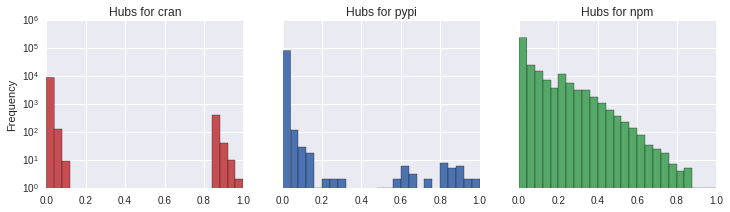

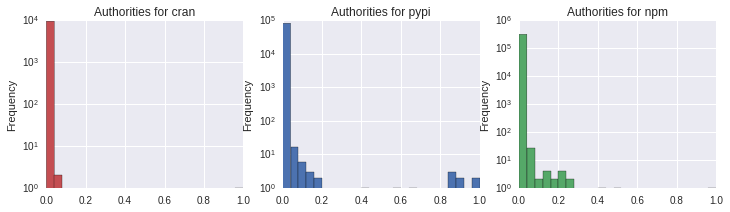

In [35]:
fig_hubs, ax_hubs = matplotlib.pyplot.subplots(ncols=3, sharey=True)
fig_hubs.set_size_inches((12, 3))

fig_auth, ax_authorities = matplotlib.pyplot.subplots(ncols=3)
fig_auth.set_size_inches((12, 3))

for i, (ecos, graph) in enumerate(graphs.items()):
    hubs, authorities = graph.hub_score(), graph.authority_score()
    hubs, authorities = pandas.Series(hubs), pandas.Series(authorities)
    hubs.plot.hist(label=ecos, ax=ax_hubs[i], bins=25, logy=True, color=COLORS[ecos])
    authorities.plot.hist(label=ecos, ax=ax_authorities[i], bins=25, logy=True, color=COLORS[ecos])
    ax_hubs[i].set_title('Hubs for {}'.format(ecos))
    ax_authorities[i].set_title('Authorities for {}'.format(ecos))

## Pagerank

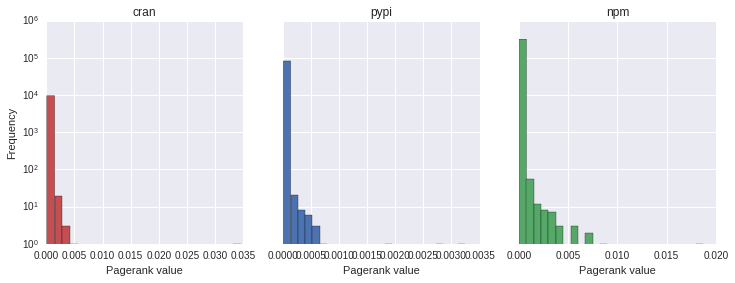

In [36]:
fig, axes = matplotlib.pyplot.subplots(ncols=3, sharey=True)
fig.set_size_inches((12, 4))

for i, (ecos, graph) in enumerate(graphs.items()):
    pagerank = graph.pagerank()
    pandas.Series(pagerank).plot.hist(label=ecos, ax=axes[i], bins=25, logy=True, color=COLORS[ecos])
    axes[i].set_title(ecos)
    axes[i].set_xlabel('Pagerank value')